<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/LoFTR_demo_single_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoFTR demo with custom image pairs on Colab
We provide an easier way to run LoFTR with a custom image pair without configuring a python environment with GPU support. Signing in your Google account is required to run this notebook in Colab.

Start by clicking Runtime --> Run all (Ctrl/Cmd + F9). 

Upload your own image pair with the "Choose Files" button to appear in the first cell. Please use horizontal images (width > height) and assign the image type (indoor/outdoor) accordingly.

In [1]:
print("Please wait for ~8 seconds for the GPU session initialization. \n \
==> Please select both images at the same time after clicking \"Choose Files\".")
!mkdir -p /content/uploaded/ && rm -rf /content/uploaded/* # clear previously uploaded images
%cd /content/uploaded/
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=file_name, length=len(uploaded[file_name])))
image_pair = ['/content/uploaded/' + f for f in list(uploaded.keys())]
%cd ..

# Change the image type here.
image_type = 'indoor'
#image_type = 'outdoor'

Please wait for ~8 seconds for the GPU session initialization. 
 ==> Please select both images at the same time after clicking "Choose Files".
/content/uploaded


Saving 1.png to 1.png
Saving 2.png to 2.png
User uploaded file "1.png" with length 5464919 bytes
User uploaded file "2.png" with length 5651092 bytes
/content


You can also choose to use the example image pair provided in the LoFTR repo (from ScanNet) by using this cell (uncommenting the last line).


In [2]:
# img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
# img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
img0_pth = "/content/uploaded/1.png"
img1_pth = "/content/uploaded/2.png"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]

In [3]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights 
%cd weights/
!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 573 kB/s 
     |████████████████████████████████| 551 kB 26.6 MB/s 
Cloning into 'LoFTR'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 173 (delta 26), reused 140 (delta 21), pack-reused 0
Receiving objects: 100% (173/173), 26.29 MiB | 21.56 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/weights
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to acce

In [4]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [5]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
image_type = 'outdoor'
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

In [6]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_pth = "/content/uploaded/1.png"
img1_pth = "/content/uploaded/2.png"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

/content/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/content/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


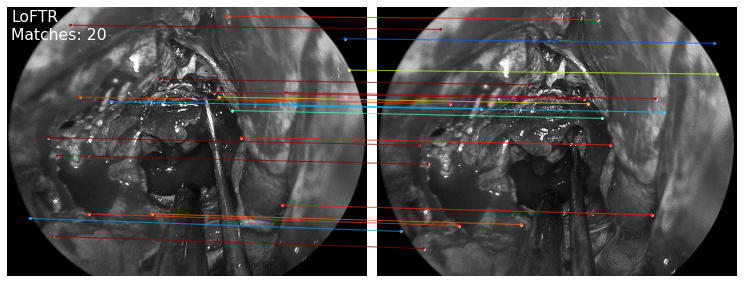

In [37]:
from google.colab import files
import random

# Draw 
num_points = 20
num_list = random.sample(range(0, len(mkpts0)), num_points)
begin = 2850
color = cm.jet(mconf[num_list], alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0[begin:begin+num_points])),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0[num_list], mkpts1[num_list], color, mkpts0[num_list], mkpts1[num_list], text)

# A high-res PDF will also be downloaded automatically.
#make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")
#files.download("LoFTR-colab-demo.pdf")